In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from e2ml.preprocessing import StandardScaler
from e2ml.experimentation import halton
from e2ml.evaluation import cross_validation, zero_one_loss, confusion_matrix

In [25]:
# Get Data
initial_molluscs_data = pd.read_csv('../../data/initial_molluscs_data.csv')
batch_1 = pd.read_csv('../../data/batch1_albayrak_labels.csv')
batch_2 = pd.read_csv('../../data/batch2_albayrak_labels.csv')
batch_3 = pd.read_csv('../../data/batch3_albayrak_labels.csv')
batch_4 = pd.read_csv('../../data/batch4_albayrak_labels.csv')
molluscs_df = pd.concat([initial_molluscs_data, batch_1, batch_2, batch_3, batch_4])

# Encode nominal features
lbl_encoder_sex = LabelEncoder()
lbl_encoder_stol = LabelEncoder()
molluscs_df['Sex'] = lbl_encoder_sex.fit_transform(molluscs_df['Sex'])
molluscs_df['Stage of Life'] = lbl_encoder_stol.fit_transform(molluscs_df['Stage of Life'])

# Split X and y
X = molluscs_df.iloc[:, :8]
y = molluscs_df.iloc[:, 8]

In [26]:
# X and y to numpy array
X = np.array(X)
y = np.array(y)

## 1. Train Classifiers

In [28]:
# Define parameters
C_upper = 1000
C_lower = 0
gamma_upper = 1
gamma_lower = 0

lr_upper = 1
lr_lower = 0
alpha_upper = 1
alpha_lower = 0

n_estimators_upper = 100
n_estimators_lower = 50
max_depth_upper = 5
max_depth_lower = 2

# Hyperparamter configurations (doe method)
theta_svc_list = halton(n_samples=20, n_dimensions=2, bounds=[(C_lower, C_upper), (gamma_lower, gamma_upper)])
theta_mlp_list = halton(n_samples=20, n_dimensions=2, bounds=[(lr_lower, lr_upper), (alpha_lower, alpha_upper)])
theta_rf_list = halton(n_samples=20, n_dimensions=2, bounds=[(n_estimators_lower, n_estimators_upper), (max_depth_lower, max_depth_upper)])

# Init helper variables
risks_svc_outer, risks_mlp_outer, risks_rf_outer = [], [], []

# Cross-Validation
n_folds = 5
sample_indices = np.arange(len(y), dtype=int)
train_outer, test_outer = cross_validation(
    sample_indices=sample_indices,
    n_folds=n_folds,
    y=y,
    random_state=0
)

# Outer k-fold loop, result: test and 'rest' set
for tr_outer, te_outer in zip(train_outer, test_outer):
    # cross_validation
    train_inner, validation_inner = cross_validation(
        sample_indices=tr_outer,
        n_folds=n_folds,
        y=y[tr_outer],
        random_state=0
    )

    # Initial best hyperparameters and risk estimates
    theta_star_svc, theta_star_mlp, theta_star_rf = None, None, None
    minimum_risk_svc, minimum_risk_mlp, minimum_risk_rf = 1, 1, 1

    # Hyperparameter loop
    for theta_svc, theta_mlp, theta_rf in zip(theta_svc_list, theta_mlp_list, theta_rf_list):
        risks_svc_inner, risks_mlp_inner, risks_rf_inner = [], [], []

        # Inner k-fold loop, result: val and train set
        for tr_inner, val_inner in zip(train_inner, validation_inner):
            # Data preprocessing
            sc_inner = StandardScaler()
            sc_inner.fit(X[tr_inner])
            X_tr_inner = sc_inner.transform(X[tr_inner])
            X_val_inner = sc_inner.transform(X[val_inner])

            # Init classifier
            svc_inner = SVC(
                C=theta_svc[0],
                gamma=theta_svc[1],
                random_state=0
            )
            svc_inner.fit(X_tr_inner, y[tr_inner])

            mlp_inner = MLPClassifier(
                learning_rate_init=theta_mlp[0],
                alpha=theta_mlp[1],
                random_state=0
            )
            mlp_inner.fit(X_tr_inner, y[tr_inner])  
            
            rf_inner = RandomForestClassifier(
                n_estimators=int(theta_rf[0]),
                max_depth=int(theta_rf[1]),
                random_state=0
            )
            rf_inner.fit(X_tr_inner, y[tr_inner])  

            # Evaluate classifier (on val set)
            y_pred_svc = svc_inner.predict(X_val_inner)
            risks_svc_inner.append(zero_one_loss(y_pred=y_pred_svc, y_true=y[val_inner]))

            y_pred_mlp = mlp_inner.predict(X_val_inner)
            risks_mlp_inner.append(zero_one_loss(y_pred=y_pred_mlp, y_true=y[val_inner]))
            
            y_pred_rf = rf_inner.predict(X_val_inner)
            risks_rf_inner.append(zero_one_loss(y_pred=y_pred_rf, y_true=y[val_inner]))
        
        # Update hyperparameter configs
        if np.mean(risks_svc_inner) <= minimum_risk_svc:
            theta_star_svc = theta_svc
            minimum_risk_svc = np.mean(risks_svc_inner)

        if np.mean(risks_mlp_inner) <= minimum_risk_mlp:
            theta_star_mlp = theta_mlp
            minimum_risk_mlp = np.mean(risks_mlp_inner)

        if np.mean(risks_rf_inner) <= minimum_risk_rf:
            theta_star_rf = theta_rf
            minimum_risk_rf = np.mean(risks_rf_inner)


    # Data preprocessing
    sc_outer = StandardScaler()
    sc_outer.fit(X[tr_outer])
    X_tr_outer = sc_outer.transform(X[tr_outer])
    X_te_outer = sc_outer.transform(X[te_outer])

    # Fit classifier (on train + val set)
    svc_outer = SVC(
        C=theta_star_svc[0],
        gamma=theta_star_svc[1],
        random_state=0
    )
    svc_outer.fit(X_tr_outer, y[tr_outer])

    mlp_outer = MLPClassifier(
        learning_rate_init=theta_star_mlp[0],
        alpha=theta_star_mlp[1],
        random_state=0
    )
    mlp_outer.fit(X_tr_outer, y[tr_outer])

    rf_outer = RandomForestClassifier(
        n_estimators=int(theta_star_rf[0]),
        max_depth=int(theta_star_rf[1]),
        random_state=0
    )
    rf_outer.fit(X_tr_outer, y[tr_outer])

    # Evaluate classifier (on test set (te_outer))
    y_pred_svc = svc_outer.predict(X_te_outer)
    risks_svc_outer.append(zero_one_loss(y_pred=y_pred_svc, y_true=y[te_outer]))

    y_pred_mlp = mlp_outer.predict(X_te_outer)
    risks_mlp_outer.append(zero_one_loss(y_pred=y_pred_mlp, y_true=y[te_outer]))
    
    y_pred_rf = rf_outer.predict(X_te_outer)
    risks_rf_outer.append(zero_one_loss(y_pred=y_pred_rf, y_true=y[te_outer]))

print(f'SVC Performance: {np.mean(risks_svc_outer)} +- {np.std(risks_svc_outer)}')
print(f'MLP Performance: {np.mean(risks_mlp_outer)} +- {np.std(risks_mlp_outer)}')
print(f'RandomForst Performance: {np.mean(risks_rf_outer)} +- {np.std(risks_rf_outer)}')

SVC Performance: 0.19788467110982322 +- 0.027675550346142858
MLP Performance: 0.27658166714961846 +- 0.020131481901264656
RandomForst Performance: 0.32675552979812617 +- 0.021900261928101145


In [32]:
# print hyperparameters
print(f'SVC: C={theta_star_svc[0]}, gamma={theta_star_svc[1]}')
print(f'MLP: lr={theta_star_mlp[0]}, alpha={theta_star_mlp[1]}')
print(f'RandomForest: n_estimators={int(theta_star_rf[0])}, max_depth={int(theta_star_rf[1])}')

SVC: C=562.5, gamma=0.037037037037037035
MLP: lr=0.03125, alpha=0.5925925925925926
RandomForest: n_estimators=62, max_depth=4


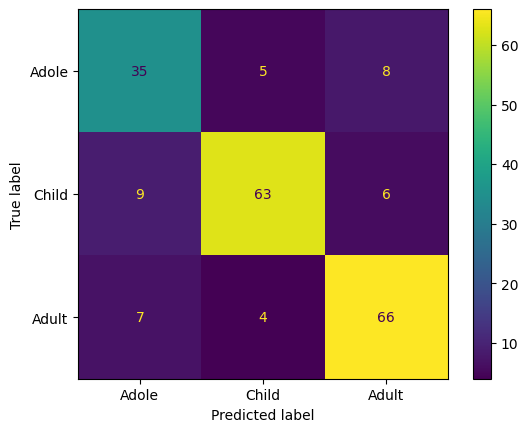

In [46]:
# Evaluate optimal models
C_svc = confusion_matrix(y_true=y[te_outer], y_pred=y_pred_svc, n_classes=3)
C_mlp = confusion_matrix(y_true=y[te_outer], y_pred=y_pred_mlp, n_classes=3)
C_rf = confusion_matrix(y_true=y[te_outer], y_pred=y_pred_rf, n_classes=3)

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(C_svc, display_labels=['Adole', 'Child', 'Adult'])
disp.plot()
